# Importation des paquets

In [1]:
import requests
from bs4 import BeautifulSoup
from shutil import copyfileobj
from urllib import request
import uuid
import xlwings as xw
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime
import re
import seaborn as sn
import sklearn.linear_model as lm
import statsmodels.api as sm
import geopandas as gpd
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# 1- Acquisition et chargement des données :

Tout d'abord, on doit acquérir l'ensemble des fichiers Excel. Ces fichiers sont disponibles sur le site https://www.vendeeglobe.org/fr/classement. En cliquant sur l'option "copier l'adresse du lien", on remarque que cette adresse est composée d'une partie fixe et une autre partie qui change selon la date du classement. Par exemple, l'adresse du lien de téléchargement du classement du 05 Mars 2021 - 08h (UTC) est https://www.vendeeglobe.org/download-race-data/vendeeglobe_20210305_080000.xlsx.

<br>On va définir une fonction <b>download_excel_files</b> dans laquelle on définit une autre fonction <b>get_ranking_dates</b> pour récupérer l'ensemble des dates (20210305_080000, 20210305_040000 ...) ce qui nous permettra d'avoir tous les liens de téléchargement.

In [2]:
def download_excel_files():
    
    ############
    def get_ranking_dates():
        url = 'https://www.vendeeglobe.org/fr/classement'
        html_code = requests.get(url).text
        soup = BeautifulSoup(html_code, 'lxml')

        liste = []

        for x in soup.find('div', {'class': "rankings__bar m--left"}).find_all('option')[1:-1]:
            liste.append(x['value'])

        return liste
    ############
    def save_with_xlwings(file):
        tempfile = file
        excel_app = xw.App(visible=False)
        excel_book = excel_app.books.open(file)
        excel_book.save(tempfile)
        excel_book.close()
        excel_app.quit()        
    ############
    for i in get_ranking_dates():
        url = 'https://www.vendeeglobe.org/download-race-data/vendeeglobe_'+str(i)+'.xlsx'
        filename = 'Excel_files/vendeeglobe_'+str(i)+'.xlsx'

        with request.urlopen(url) as response, open(filename, 'wb') as out_file:
            copyfileobj(response, out_file)
        
        save_with_xlwings('Excel_files/vendeeglobe_'+str(i)+'.xlsx')

In [3]:
# download_excel_files()

Ensuite, on définit une fonction <b>get_boats_infos</b> qui nous permet d'acquérir les caractéristiques de chaque voile.

In [4]:
def get_boats_infos():
    url = 'https://www.vendeeglobe.org/fr/glossaire'
    html_code = requests.get(url).text
    soup = BeautifulSoup(html_code, 'lxml')
    
    df = pd.DataFrame(columns=["Nom du skipper",
                               "Nom du voile",
                               "Numéro de voile",
                               "Anciens noms du bateau",
                               "Architecte",
                               "Chantier",
                               "Date de lancement",
                               "Longueur",
                               "Largeur",
                               "Tirant d'eau",
                               "Déplacement (poids)",
                               "Nombre de dérives",
                               "Hauteur mât",
                               "Voile quille",
                               "Surface de voiles au près",
                               "Surface de voiles au portant"])
    
    for element in soup.find_all('div', {'class': "sv-u-1 sv-u-s-1-2 sv-u-m-1-3 sv-u-l-1-6"}) :
        skipper = element.find('span', {'class': "boats-list__skipper-name"}).text
        bateau = element.find('h3', {'class': "boats-list__boat-name"}).text
        
        new_row = {'Nom du skipper': skipper, 'Nom du voile': bateau}
        
        if bateau == '':
            new_row.pop('Nom du voile')
            
        for x in element.find('ul', {'class': 'boats-list__popup-specs-list'}).find_all('li'):
            new_row[x.text.split(' : ')[0]] = x.text.split(' : ')[1]
        
        new_df = pd.DataFrame([new_row])
        
        df = pd.concat([df, new_df], axis=0, ignore_index=True)
        
    df = df.set_index('Nom du skipper')
    
    return df

In [5]:
get_boats_infos()

Nom du voile Numéro de voile  \
Nom du skipper                                                             
Fabrice AMEDEO                  NEWREST - ART & FENÊTRES          FRA 56   
Romain ATTANASIO                    PURE - Best Western®          FRA 49   
Alexia BARRIER                          TSE -  4MYPLANET           FRA72   
Yannick BESTAVEN                           Maître CoQ IV              17   
Jérémie BEYOU                                     CHARAL              08   
Arnaud BOISSIÈRES      LA MIE CÂLINE - ARTISANS ARTIPÔLE          FRA 14   
Louis BURTON                             BUREAU VALLEE 2              18   
Didac COSTA                         ONE PLANET ONE OCEAN          ESP 33   
Manuel COUSIN                               GROUPE SÉTIN          FRA 71   
Clarisse CREMER                       BANQUE POPULAIRE X           FRA30   
Charlie DALIN                                     APIVIA          FRA 79   
Sam DAVIES                             INITIATIVES-COEUR          FRA109   
Sébastien DESTREMAU                                MERCI              69   
Benjamin DUTREUX                    OMIA - WATER FAMILY            FRA09   
Kevin ESCOFFIER                                      PRB          FRA 85   
Clément GIRAUD                 Compagnie du Lit / Jiliti           FRA83   
François Guiffant                                    NaN             NaN   
Pip HARE                                        MEDALLIA           GBR77   
Boris HERRMANN        SEAEXPLORER - YACHT CLUB DE MONACO              16   
Ari HUUSELA                                        STARK          FIN222   
Isabelle JOSCHKE                                   MACSF          FRA 27   
Jean LE CAM                                  Yes We Cam!             001   
Stéphane LE DIRAISON                     TIME FOR OCEANS          FRA 92   
Miranda MERRON                        CAMPAGNE DE FRANCE           FRA50   
Giancarlo PEDOTE                          PRYSMIAN GROUP          ITA 34   
Alan  ROURA                                  LA FABRIQUE           SUI07   
Thomas RUYANT                                  LinkedOut             NaN   
Damien SEGUIN                              GROUPE APICIL         FRA1000   
Kojiro SHIRAISHI                     DMG MORI Global One          JPN 11   
Sébastien SIMON                             ARKEA PAPREC               4   
Maxime SOREL                             V and B-MAYENNE           FRA53   
Alex THOMSON                                   HUGO BOSS          GBR 99   
Armel TRIPON                      L'OCCITANE EN PROVENCE               2   
Nicolas TROUSSEL                         CORUM L'EPARGNE           FRA 6   

                                                 Anciens noms du bateau  \
Nom du skipper                                                            
Fabrice AMEDEO                           No Way Back, Vento di Sardegna   
Romain ATTANASIO               Gitana Eighty, Synerciel, Newrest-Matmut   
Alexia BARRIER        Famille Mary-Etamine du Lys, Initiatives Coeur...   
Yannick BESTAVEN                          Safran 2 - Des Voiles et Vous   
Jérémie BEYOU                                                       NaN   
Arnaud BOISSIÈRES     Ecover3, Président, Gamesa, Kilcullen Voyager-...   
Louis BURTON                                      Banque Populaire VIII   
Didac COSTA           Kingfisher - Educacion sin Fronteras - Forum M...   
Manuel COUSIN         Paprec-Virbac2, Estrella Damm, We are Water, L...   
Clarisse CREMER                                             Macif - SMA   
Charlie DALIN                                                       NaN   
Sam DAVIES                 Maître CoQ - Banque Populaire VII- Foncia II   
Sébastien DESTREMAU               Foresight Natural Energy, Maisonneuve   
Benjamin DUTREUX      Spirit of Yukoh, Neutrogena, Hugo Boss, Estrel...   
Kevin ESCOFFIER                                                     NaN   
Clément GIRAUD        Delta Dore

# 2- Préparation des données :

### 2-1- Traitement des fichiers excel :

On prend l'exemple du classement du 22 Novembre 2022 - 08h (UTC) :

##### Avant traitement :

In [6]:
pd.read_excel('Excel_files/vendeeglobe_20201122_080000.xlsx')

Unnamed: 0                                         Unnamed: 1  \
0          NaN                                                NaN   
1          NaN  Classement du dimanche 22 novembre 2020 à 09h0...   
2          NaN                                         Rang\nRank   
3          NaN                                                NaN   
4          NaN                                                  1   
5          NaN                                                  2   
6          NaN                                                  3   
7          NaN                                                  4   
8          NaN                                                  5   
9          NaN                                                  6   
10         NaN                                                  7   
11         NaN                                                  8   
12         NaN                                                  9   
13         NaN                                                 10   
14         NaN                                                 11   
15         NaN                                                 12   
16         NaN                                                 13   
17         NaN                                                 14   
18         NaN                                                 15   
19         NaN                                                 16   
20         NaN                                                 17   
21         NaN                                                 18   
22         NaN                                                 19   
23         NaN                                                 20   
24         NaN                                                 21   
25         NaN                                                 22   
26         NaN                                                 23   
27         NaN                                                 24   
28         NaN                                                 25   
29         NaN                                                 26   
30         NaN                                                 27   
31         NaN                                                 28   
32         NaN                                                 29   
33         NaN                                                 30   
34         NaN                                                 31   
35         NaN                                                 32   
36         NaN                                                RET   
37         NaN  Traitements et calculs : Géovoile, un service ...   
38         NaN                                                NaN   
39         NaN  VMG : Velocity Made Good = projection du vecte...   
40         NaN  DTF : Distance To Finish = Distance théorique ...   

                   Unnamed: 2  \
0                         NaN   
1                         NaN   
2   Nat. / Voile\nNat. / Sail   
3                         NaN   
4                    \nFRA 59   
5                    \nFRA 79   
6                    \nGBR 99   
7                    \nFRA 01   
8                    \nFRA 85   
9                    \nMON 10   
10                   \nFRA 17   
11                   \nFRA 18   
12                    \nFRA 4   
13                  \nFRA 109   
14                   \nFRA 09   
15                 \nFRA 1000   
16                   \nITA 34   
17                   \nFRA 53   
18                   \nFRA 27   
19                   \nFRA 30   
20                   \nFRA 49   
21                    \nSUI 7   
22                   \nFRA 92   
23                   \nESP 33   
24                  \nGBR 777   
25                   \nFRA 14   
26                   \nFRA 71   
27                 FR\nFRA 02   
28                   \nFRA 72   
29                   \nFRA 83   
30                   \nFRA 50   
31                  \nFIN 222   
32              

##### Après Traitement :

In [7]:
def prepare_excel_files(date):
    df = pd.read_excel('Excel_files/vendeeglobe_'+date+'.xlsx')
    i = df.loc[df['Unnamed: 1']=='Traitements et calculs : Géovoile, un service Hauwell Studios'].index[0]
    df = df.iloc[4:i,1:].reset_index(drop=True)
    c = df.columns.tolist()
    df = df[c[0:6]+[c[6]]+[c[10]]+[c[14]]+[c[7]]+[c[11]]+[c[15]]+[c[8]]+[c[12]]+[c[16]]+[c[9]]+[c[13]]+[c[17]]+c[18:]]

    cols = [('Rang',''),
            ('Nat/Voile',''),
            ('Skipper/Bateau',''),
            ('Heure (UTC)',''),
            ('Latitude',''),
            ('Longitude',''),
            ('Cap (°)','Depuis 30 minutes'),
            ('Cap (°)','Depuis le dernier classement'),
            ('Cap (°)','Depuis 24 heures'),
            ('Vitesse (kts)','Depuis 30 minutes'),
            ('Vitesse (kts)','Depuis le dernier classement'),
            ('Vitesse (kts)','Depuis 24 heures'),
            ('VMG (kts)','Depuis 30 minutes'),
            ('VMG (kts)','Depuis le dernier classement'),
            ('VMG (kts)','Depuis 24 heures'),
            ('Distance (nm)','Depuis 30 minutes'),
            ('Distance (nm)','Depuis le dernier classement'),
            ('Distance (nm)','Depuis 24 heures'),
            ('DTF (nm)',''),
            ('DTL (nm)','')]

    df.columns = pd.MultiIndex.from_tuples(cols)

    # Nationalité, numéro et nom du voile, nom du skipper
    nat_voile = df['Nat/Voile'].str.split("\n").str[1].str.split(" ")
    skipper_bateau = df['Skipper/Bateau'].str.split("\n")
    skipper = skipper_bateau.apply(lambda x: x[0]).str.split(" ", n=1)

    df['Nationalité'] = nat_voile.apply(lambda x: x[0])
    df['Numéro du voile'] = nat_voile.apply(lambda x: x[1])
    df['Numéro du voile'] = df['Numéro du voile'].str.zfill(2)
    df['Nom du skipper'] = skipper.apply(lambda x: x[0].capitalize()+" "+x[1].upper())
    df['Nom du voile'] = skipper_bateau.apply(lambda x: x[1])

    c = df.columns.tolist()
    df = df[[c[0]]+ c[-4:] + c[3:-4]]

    # Heure (on choisit les heures UTC et non pas FR)
    df['Heure (UTC)'] = pd.to_datetime(df['Heure (UTC)'].str.split(" ").str[0], format='%H:%M')
    df['Heure (UTC)'] = df['Heure (UTC)'].apply(lambda x: x - datetime.timedelta(hours=1))
    df['Heure (UTC)'] = df['Heure (UTC)'].dt.time

    # Latitude et Longitude : conversion degrés, minutes, secondes => décimal
    def get_latitude(lat_degree):
        liste = re.split("°|\.|'", lat_degree)
        if liste[3] == 'N':
            lat_decimal = int(liste[0]) + int(liste[1])/60 + int(liste[2])/3600
        else:
            lat_decimal = -(int(liste[0])+ int(liste[1])/60 + int(liste[2])/3600)
        return lat_decimal

    def get_longitude(lon_degree):
        liste = re.split("°|\.|'", lon_degree)
        if liste[3] == 'E':
            lon_decimal = int(liste[0]) + int(liste[1])/60 + int(liste[2])/3600
        else:
            lon_decimal = -(int(liste[0])+ int(liste[1])/60 + int(liste[2])/3600)
        return lon_decimal

    df['Latitude'] = df['Latitude'].apply(lambda x: get_latitude(x) if pd.notnull(x) else x)
    df['Longitude'] = df['Longitude'].apply(lambda x: get_longitude(x) if pd.notnull(x) else x)

    # Cap (°), Vitesse (kts), VMG (kts), Distance (nm)
    df['Cap (°)'] = df['Cap (°)'].apply(lambda x: x.str.rstrip('°')).apply(pd.to_numeric)
    df['Vitesse (kts)'] = df['Vitesse (kts)'].apply(lambda x: x.str.rstrip(" kts")).apply(pd.to_numeric)
    df['VMG (kts)'] = df['VMG (kts)'].apply(lambda x: x.str.rstrip(" kts")).apply(pd.to_numeric)
    df['Distance (nm)'] = df['Distance (nm)'].apply(lambda x: x.str.rstrip(" nm")).apply(pd.to_numeric)

    # DTF (nm) et DTL (nm)
    df['DTF (nm)'] = pd.to_numeric(df['DTF (nm)'].str.rstrip(" nm"))
    df['DTL (nm)'] = pd.to_numeric(df['DTL (nm)'].str.rstrip(" nm"))
    
    return df

In [8]:
prepare_excel_files('20201122_080000')

Rang Nationalité Numéro du voile        Nom du skipper  \
                                                            
0     1         FRA              59         Thomas RUYANT   
1     2         FRA              79         Charlie DALIN   
2     3         GBR              99          Alex THOMSON   
3     4         FRA              01           Jean LE CAM   
4     5         FRA              85       Kevin ESCOFFIER   
5     6         MON              10        Boris HERRMANN   
6     7         FRA              17      Yannick BESTAVEN   
7     8         FRA              18          Louis BURTON   
8     9         FRA              04       Sébastien SIMON   
9    10         FRA             109       Samantha DAVIES   
10   11         FRA              09      Benjamin DUTREUX   
11   12         FRA            1000         Damien SEGUIN   
12   13         ITA              34      Giancarlo PEDOTE   
13   14         FRA              53          Maxime SOREL   
14   15         FRA              27      Isabelle JOSCHKE   
15   16         FRA              30       Clarisse CREMER   
16   17         FRA              49      Romain ATTANASIO   
17   18         SUI              07            Alan ROURA   
18   19         FRA              92  Stéphane LE DIRAISON   
19   20         ESP              33           Didac COSTA   
20   21         GBR             777              Pip HARE   
21   22         FRA              14     Arnaud BOISSIERES   
22   23         FRA              71         Manuel COUSIN   
23   24         FRA              02          Armel TRIPON   
24   25         FRA              72        Alexia BARRIER   
25   26         FRA              83        Clément GIRAUD   
26   27         FRA              50        Miranda MERRON   
27   28         FIN             222           Ari HUUSELA   
28   29         FRA              69   Sébastien DESTREMAU   
29   30         FRA              56        Fabrice AMEDEO   
30   31         JPN              11      Kojiro SHIRAISHI   
31   32         FRA              08         Jérémie BEYOU   
32  RET         FRA              06      Nicolas TROUSSEL   

                              Nom du voile Heure (UTC)   Latitude  Longitude  \
                                                                               
0                                LinkedOut    07:30:00 -25.158889 -24.684444   
1                                   APIVIA    07:30:00 -25.239722 -25.440556   
2                                HUGO BOSS    07:30:00 -24.770833 -26.850000   
3                             Yes we Cam !    07:30:00 -20.990556 -26.210278   
4                                      PRB    07:30:00 -22.051667 -29.125556   
5       Seaexplorer - Yacht Club De Monaco    07:30:00 -21.350000 -29.411667   
6                            Maître Coq IV    07:30:00 -20.576944 -28.766667   
7                          Bureau Vallée 2    07:30:00 -21.629722 -30.529722   
8                             ARKEA PAPREC    07:30:00 -21.361667 -30.458056   
9                      Initiatives - Coeur    07:30:00 -20.476389 -30.125833   
10                     OMIA - Water Family    07:30:00 -15.803056 -29.238611   
11                           Groupe APICIL    07:30:00 -15.999722 -30.452222   
12                          Prysmian Group    07:30:00 -16.423611 -31.769444   
13                         V And B Mayenne    07:30:00 -12.290278 -30.059722   
14                                   MACSF    07:30:00 -11.387778 -30.384444   
15                      Banque Populaire X    07:30:00  -9.366111 -30.128056   
16  Pure - Best Western Hotels and Resorts    07:30:00  -9.289722 -30.221944   
17                             La Fabrique    07:30:00  -8.536111 -30.510556   
18                         Time For Oceans    07:30:00  -3.855278 -30.595556   
19                    One Planet One Ocean    07:30:00   4.541389 -28.036667   
20                                Medallia    07:30:00   4.374722 -28.984722   
21       La Mie Câline - Ar

In [9]:
prepare_excel_files('20201122_080000').dtypes

Rang                                              object
Nationalité                                       object
Numéro du voile                                   object
Nom du skipper                                    object
Nom du voile                                      object
Heure (UTC)                                       object
Latitude                                         float64
Longitude                                        float64
Cap (°)          Depuis 30 minutes               float64
                 Depuis le dernier classement    float64
                 Depuis 24 heures                float64
Vitesse (kts)    Depuis 30 minutes               float64
                 Depuis le dernier classement    float64
                 Depuis 24 heures                float64
VMG (kts)        Depuis 30 minutes               float64
                 Depuis le dernier classement    float64
                 Depuis 24 heures                float64
Distance (nm)    Depuis 30 minu

Cependant, ce programme n'est valable que pour certains fichiers puisque vers la fin de la course, le format des fichiers Excel change avec les arrivées des voiliers. On va donc s'arrêter juste avant. Le nouveau format commence dès le classement du 27 Janvier 2021 à 17h (UTC). Nous allons nous contenter des classements sortis avant cette date, c'est-à-dire jusqu'à celui du 27 Janvier 2021 à 14h (UTC).

In [10]:
def get_ranking_dates():
        url = 'https://www.vendeeglobe.org/fr/classement'
        html_code = requests.get(url).text
        soup = BeautifulSoup(html_code, 'lxml')

        liste = []

        for x in soup.find('div', {'class': "rankings__bar m--left"}).find_all('option')[1:-1]:
            liste.append(x['value'])

        return liste

In [11]:
liste_dates = list(reversed(get_ranking_dates()))
liste_dates = liste_dates[:liste_dates.index('20210127_170000')]

In [12]:
liste_dataframes = []

for d in liste_dates:
    df = prepare_excel_files(d)
    df['Date du classement'] = pd.to_datetime(d, format="%Y%m%d_%H%M%S")
    df.set_index('Date du classement', append=True, inplace=True)
    df = df.swaplevel()
    liste_dataframes.append(df)
    print(d)

20201108_140000
20201108_150000
20201108_170000
20201108_210000
20201109_040000
20201109_080000
20201109_110000
20201109_140000
20201109_170000
20201109_210000
20201110_040000
20201110_080000
20201110_110000
20201110_140000
20201110_170000
20201110_210000
20201111_040000
20201111_080000
20201111_110000
20201111_140000
20201111_170000
20201111_210000
20201112_040000
20201112_080000
20201112_110000
20201112_140000
20201112_170000
20201112_210000
20201113_040000
20201113_080000
20201113_110000
20201113_140000
20201113_170000
20201113_210000
20201114_040000
20201114_080000
20201114_110000
20201114_140000
20201114_170000
20201114_210000
20201115_040000
20201115_080000
20201115_110000
20201115_140000
20201115_170000
20201115_210000
20201116_040000
20201116_080000
20201116_110000
20201116_140000
20201116_170000
20201116_210000
20201117_040000
20201117_080000
20201117_110000
20201117_140000
20201117_170000
20201117_210000
20201118_040000
20201118_080000
20201118_110000
20201118_140000
20201118

In [13]:
len(liste_dates) == len(liste_dataframes)

True

In [14]:
df_classements = pd.concat(liste_dataframes)

In [15]:
df_classements

Rang Nationalité Numéro du voile    Nom du skipper  \
                                                                            
Date du classement                                                          
2020-11-08 14:00:00 0     1         FRA              18      Louis BURTON   
                    1     2         MON              10    Boris HERRMANN   
                    2     3         FRA              08     Jérémie BEYOU   
                    3     4         FRA              59     Thomas RUYANT   
                    4     5         FRA              53      Maxime SOREL   
...                     ...         ...             ...               ...   
2021-01-27 14:00:00 28  RET         FRA             109   Samantha DAVIES   
                    29  RET         FRA              04   Sébastien SIMON   
                    30  RET         GBR              99      Alex THOMSON   
                    31  RET         FRA              85   Kevin ESCOFFIER   
                    32  RET         FRA              06  Nicolas TROUSSEL   

                                              Nom du voile Heure (UTC)  \
                                                                         
Date du classement                                                       
2020-11-08 14:00:00 0                      Bureau Vallée 2    14:30:00   
                    1   Seaexplorer - Yacht Club De Monaco    14:31:00   
                    2                               Charal    14:30:00   
                    3                            LinkedOut    14:30:00   
                    4                      V And B Mayenne    14:30:00   
...                                                    ...         ...   
2021-01-27 14:00:00 28                 Initiatives - Coeur         NaT   
                    29                        ARKEA PAPREC         NaT   
                    30                           HUGO BOSS         NaT   
                    31                                 PRB         NaT   
                    32                     CORUM L'Épargne         NaT   

                         Latitude Longitude           Cap (°)  \
                                            Depuis 30 minutes   
Date du classement                                              
2020-11-08 14:00:00 0   46.412778 -1.846667             241.0   
                    1   46.409444 -1.839444             241.0   
                    2   46.425278 -1.844167             244.0   
                    3   46.419722 -1.835556             244.0   
                    4   46.416389 -1.832222             246.0   
...                           ...       ...               ...   
2021-01-27 14:00:00 28        NaN       NaN               NaN   
                    29        NaN       NaN               NaN   
                    30        NaN       NaN               NaN   
                    31        NaN       NaN               NaN   
                    32        NaN       NaN               NaN   

                                                     ...  \
                       Depuis le dernier classement  ...   
Date du classement                                   ...   
2020-11-08 14:00:00 0                         357.0  ...   
                    1                         357.0  ...   
                    2                         357.0  ...   
                    3                         357.0  ...   
                    4                         357.0  ...   
...                                             ...  ...   
2021-01-27 14:00:00 28                          NaN  ...   
                    29                          NaN  ...   
                    30                          NaN  ...   
                    31                          NaN  ...   
                    32                          NaN  ...   

                                      Vitesse (kts)                   \
                       Depuis le dernier classement Depuis 24 heures   
Date du cla

### 2-2- Traitement du DataFrame des caractéristiques des voiles :

In [16]:
def prepare_boats_infos():
    # Noms des skippers
    df = get_boats_infos().reset_index()
    nom = df['Nom du skipper'].str.split(" ", n=1)
    df['Nom du skipper'] = nom.apply(lambda x: x[0].capitalize()+" "+x[1].upper())
    df = df.set_index('Nom du skipper')
    # Nationalité - Numéro de voile
    df['Nat/Num'] = ['FRA 56', 'FRA 49', 'FRA 72', 'FRA 17', 'FRA 08', 'FRA 14', 'FRA 18', 'ESP 33', 'FRA 71', 
                     'FRA 30', 'FRA 79', 'FRA 109', 'FRA 69', 'FRA 09', 'FRA 85', 'FRA 83', np.nan, 'GBR 777', 
                     'MON 10', 'FIN 222', 'FRA 27', 'FRA 01', 'FRA 92', 'FRA 50', 'ITA 34', 'SUI 07', 'FRA 59', 
                     'FRA 1000', 'JPN 11', 'FRA 04', 'FRA 53', 'GBR 99', 'FRA 02', 'FRA 06']
    df['Nationalité'] = df['Nat/Num'].str.split(" ").str[0]
    df['Numéro du voile'] = df['Nat/Num'].str.split(" ").str[1]
    df = df.drop('Numéro de voile', axis=1)
    df = df.drop('Nat/Num', axis=1)

    # Date de lancement
    Mois_francais = ['Janvier', 'Février', 'Mars', 'Avril', 'Mai', 'Juin', 'Juillet', 'Août', 'Septembre']
    Mois_anglais = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September']
    for i in range(9):
        df['Date de lancement'] = df['Date de lancement'].str.replace(Mois_francais[i], Mois_anglais[i])
    df['Date de lancement'] = pd.to_datetime(df['Date de lancement'], format='%d %B %Y')
    
    # Longueur, Largeur, Tirant d'eau, Déplacement (poids), Hauteur mât, Surface de voiles au près, Surface de voiles au portant
    df['Longueur'] = df['Longueur'].apply(lambda x: re.findall(r"\d+,?\d*", x)[0] if pd.notnull(x) else x)
    df['Largeur'] = df['Largeur'].apply(lambda x: re.findall(r"\d+,?\d*", x)[0] if pd.notnull(x) else x)
    df["Tirant d'eau"] = df["Tirant d'eau"].apply(lambda x: re.findall(r"\d+,?\d*", x)[0] if pd.notnull(x) else x)
    df.loc[df['Déplacement (poids)'].isin(['NC', 'nc']), 'Déplacement (poids)'] = np.nan
    df['Déplacement (poids)'] = df['Déplacement (poids)'].apply(lambda x: re.findall(r"\d+,?\d*", x)[0] if pd.notnull(x) else x)
    df['Hauteur mât'] = df['Hauteur mât'].apply(lambda x: re.findall(r"\d+,?\d*", x)[0] if pd.notnull(x) else x)
    df['Surface de voiles au près'] = df['Surface de voiles au près'].apply(lambda x: re.findall(r"\d+,?\d*", x)[0] if pd.notnull(x) else x)
    df['Surface de voiles au portant'] = df['Surface de voiles au portant'].apply(lambda x: re.findall(r"\d+,?\d*", x)[0] if pd.notnull(x) else x)
    
    df['Longueur'] = df['Longueur'].str.replace(',', '.')
    df['Largeur'] = df['Largeur'].str.replace(',', '.')
    df["Tirant d'eau"] = df["Tirant d'eau"].str.replace(',', '.')
    df['Déplacement (poids)'] = df['Déplacement (poids)'].str.replace(',', '.')
    df['Hauteur mât'] = df['Hauteur mât'].str.replace(',', '.')
    df['Longueur'] = df['Longueur'].str.replace(',', '.')
    
    df['Longueur'] = pd.to_numeric(df['Longueur'])
    df['Largeur'] = pd.to_numeric(df['Largeur'])
    df["Tirant d'eau"] = pd.to_numeric(df["Tirant d'eau"])
    df['Déplacement (poids)'] = pd.to_numeric(df['Déplacement (poids)'])
    df['Hauteur mât'] = pd.to_numeric(df['Hauteur mât'])
    df['Surface de voiles au près'] = pd.to_numeric(df['Surface de voiles au près'])
    df['Surface de voiles au portant'] = pd.to_numeric(df['Surface de voiles au portant'])

    # Ordre des colonnes
    cols = df.columns.tolist()
    df = df[[cols[0]] + cols[-2:] + cols[1:-2]]
    
    return df

In [17]:
df_boats_infos = prepare_boats_infos()

In [18]:
df_boats_infos

Nom du voile Nationalité  \
Nom du skipper                                                         
Fabrice AMEDEO                  NEWREST - ART & FENÊTRES         FRA   
Romain ATTANASIO                    PURE - Best Western®         FRA   
Alexia BARRIER                          TSE -  4MYPLANET         FRA   
Yannick BESTAVEN                           Maître CoQ IV         FRA   
Jérémie BEYOU                                     CHARAL         FRA   
Arnaud BOISSIÈRES      LA MIE CÂLINE - ARTISANS ARTIPÔLE         FRA   
Louis BURTON                             BUREAU VALLEE 2         FRA   
Didac COSTA                         ONE PLANET ONE OCEAN         ESP   
Manuel COUSIN                               GROUPE SÉTIN         FRA   
Clarisse CREMER                       BANQUE POPULAIRE X         FRA   
Charlie DALIN                                     APIVIA         FRA   
Sam DAVIES                             INITIATIVES-COEUR         FRA   
Sébastien DESTREMAU                                MERCI         FRA   
Benjamin DUTREUX                    OMIA - WATER FAMILY          FRA   
Kevin ESCOFFIER                                      PRB         FRA   
Clément GIRAUD                 Compagnie du Lit / Jiliti         FRA   
François GUIFFANT                                    NaN         NaN   
Pip HARE                                        MEDALLIA         GBR   
Boris HERRMANN        SEAEXPLORER - YACHT CLUB DE MONACO         MON   
Ari HUUSELA                                        STARK         FIN   
Isabelle JOSCHKE                                   MACSF         FRA   
Jean LE CAM                                  Yes We Cam!         FRA   
Stéphane LE DIRAISON                     TIME FOR OCEANS         FRA   
Miranda MERRON                        CAMPAGNE DE FRANCE         FRA   
Giancarlo PEDOTE                          PRYSMIAN GROUP         ITA   
Alan  ROURA                                  LA FABRIQUE         SUI   
Thomas RUYANT                                  LinkedOut         FRA   
Damien SEGUIN                              GROUPE APICIL         FRA   
Kojiro SHIRAISHI                     DMG MORI Global One         JPN   
Sébastien SIMON                             ARKEA PAPREC         FRA   
Maxime SOREL                             V and B-MAYENNE         FRA   
Alex THOMSON                                   HUGO BOSS         GBR   
Armel TRIPON                      L'OCCITANE EN PROVENCE         FRA   
Nicolas TROUSSEL                         CORUM L'EPARGNE         FRA   

                     Numéro du voile  \
Nom du skipper                         
Fabrice AMEDEO                    56   
Romain ATTANASIO                  49   
Alexia BARRIER                    72   
Yannick BESTAVEN                  17   
Jérémie BEYOU                     08   
Arnaud BOISSIÈRES                 14   
Louis BURTON                      18   
Didac COSTA                       33   
Manuel COUSIN                     71   
Clarisse CREMER                   30   
Charlie DALIN                     79   
Sam DAVIES                       109   
Sébastien DESTREMAU               69   
Benjamin DUTREUX                  09   
Kevin ESCOFFIER                   85   
Clément GIRAUD                    83   
François GUIFFANT                NaN   
Pip HARE                         777   
Boris HERRMANN                    10   
Ari HUUSELA                      222   
Isabelle JOSCHKE                  27   
Jean LE CAM                       01   
Stéphane LE DIRAISON              92   
Miranda MERRON                    50   
Giancarlo PEDOTE                  34   
Alan  ROURA                       07   
Thomas RUYANT                     59   
Damien SEGUIN                   1000   
Kojiro SHIRAISHI                  11   
Sébastien SIMON                   04   
Maxime SOREL                      53   
Alex THOMSON                      99   
Armel TRIPON                      02   
Nicolas TROUSSEL                  06   

          

### 2-3- Valeurs manquantes :

##### df_classements :

In [19]:
cols = df_classements.columns.tolist()

pd.DataFrame({
              'Colonne': 
              cols,
              
              'Nombre de valeurs manquantes': 
              [df_classements[col].isnull().sum() for col in cols],
              
              'Pourcentage de valeurs manquantes': 
              [round(((df_classements[col].isnull().sum())*100/(len(df_classements.index))),2).astype(str)+' %' for col in cols]
             })

Colonne  \
0                                        (Rang, )   
1                                 (Nationalité, )   
2                             (Numéro du voile, )   
3                              (Nom du skipper, )   
4                                (Nom du voile, )   
5                                 (Heure (UTC), )   
6                                    (Latitude, )   
7                                   (Longitude, )   
8                    (Cap (°), Depuis 30 minutes)   
9         (Cap (°), Depuis le dernier classement)   
10                    (Cap (°), Depuis 24 heures)   
11             (Vitesse (kts), Depuis 30 minutes)   
12  (Vitesse (kts), Depuis le dernier classement)   
13              (Vitesse (kts), Depuis 24 heures)   
14                 (VMG (kts), Depuis 30 minutes)   
15      (VMG (kts), Depuis le dernier classement)   
16                  (VMG (kts), Depuis 24 heures)   
17             (Distance (nm), Depuis 30 minutes)   
18  (Distance (nm), Depuis le dernier classement)   
19              (Distance (nm), Depuis 24 heures)   
20                                   (DTF (nm), )   
21                                   (DTL (nm), )   

    Nombre de valeurs manquantes Pourcentage de valeurs manquantes  
0                              0                             0.0 %  
1                              0                             0.0 %  
2                              0                             0.0 %  
3                              0                             0.0 %  
4                              0                             0.0 %  
5                           2221                           13.88 %  
6                           2221                           13.88 %  
7                           2221                           13.88 %  
8                           2221                           13.88 %  
9                           2221                           13.88 %  
10                          2221                           13.88 %  
11                          2221                           13.88 %  
12                          2221                           13.88 %  
13                          2221                           13.88 %  
14                          2221                           13.88 %  
15                          2221                           13.88 %  
16                          2221                           13.88 %  
17                          2221                           13.88 %  
18                          2221                           13.88 %  
19                          2221                           13.88 %  
20                          2221                           13.88 %  
21                          2221                           13.88 %

In [20]:
array = df_classements.loc[df_classements['Heure (UTC)'].isna()].index.values
for col in cols[6:]:
    print(str(col) + " ==> " + str((array == df_classements.loc[df_classements[col].isna()].index.values).all()))

('Latitude', '') ==> True
('Longitude', '') ==> True
('Cap (°)', 'Depuis 30 minutes') ==> True
('Cap (°)', 'Depuis le dernier classement') ==> True
('Cap (°)', 'Depuis 24 heures') ==> True
('Vitesse (kts)', 'Depuis 30 minutes') ==> True
('Vitesse (kts)', 'Depuis le dernier classement') ==> True
('Vitesse (kts)', 'Depuis 24 heures') ==> True
('VMG (kts)', 'Depuis 30 minutes') ==> True
('VMG (kts)', 'Depuis le dernier classement') ==> True
('VMG (kts)', 'Depuis 24 heures') ==> True
('Distance (nm)', 'Depuis 30 minutes') ==> True
('Distance (nm)', 'Depuis le dernier classement') ==> True
('Distance (nm)', 'Depuis 24 heures') ==> True
('DTF (nm)', '') ==> True
('DTL (nm)', '') ==> True


Les mêmes lignes possèdent des valeurs manquantes dans les colonnes 5 à 21. En d'autres termes, il y a 2221 lignes qui contiennent au moins une valeur manquante.

In [21]:
print("Nombre de lignes avec Rang = 'NL' : "+str(len(df_classements.loc[df_classements['Rang']=='NL'])))
print("Nombre de lignes avec Rang = 'RET' : "+str(len(df_classements.loc[df_classements['Rang']=='RET'])))

Nombre de lignes avec Rang = 'NL' : 5
Nombre de lignes avec Rang = 'RET' : 2216


On remarque que 2216 + 5 = 2221

In [22]:
len(df_classements.loc[(df_classements['Rang']=='NL') & (df_classements['Heure (UTC)'].isna())])

5

In [23]:
len(df_classements.loc[(df_classements['Rang']=='RET') & (df_classements['Heure (UTC)'].isna())])

2216

<b>Conclusion :</b> Les lignes qui contiennent des valeurs NaN sont celles où le rang vaut soit 'NL', soit 'RET'.
<br>➜ On peut négliger ces lignes dans la suite.

##### df_boats_infos :

In [24]:
cols = df_boats_infos.columns.tolist()

pd.DataFrame({
              'Colonne': 
              cols,
              
              'Nombre de valeurs manquantes': 
              [df_boats_infos[col].isnull().sum() for col in cols],
              
              'Pourcentage de valeurs manquantes': 
              [round(((df_boats_infos[col].isnull().sum())*100/(len(df_boats_infos.index))),2).astype(str)+' %' for col in cols]
             })

Colonne  Nombre de valeurs manquantes  \
0                   Nom du voile                             1   
1                    Nationalité                             1   
2                Numéro du voile                             1   
3         Anciens noms du bateau                            10   
4                     Architecte                             1   
5                       Chantier                             1   
6              Date de lancement                             0   
7                       Longueur                             1   
8                        Largeur                             1   
9                   Tirant d'eau                             1   
10           Déplacement (poids)                             3   
11             Nombre de dérives                             1   
12                   Hauteur mât                             1   
13                  Voile quille                             2   
14     Surface de voiles au près                             1   
15  Surface de voiles au portant                             1   

   Pourcentage de valeurs manquantes  
0                             2.94 %  
1                             2.94 %  
2                             2.94 %  
3                            29.41 %  
4                             2.94 %  
5                             2.94 %  
6                              0.0 %  
7                             2.94 %  
8                             2.94 %  
9                             2.94 %  
10                            8.82 %  
11                            2.94 %  
12                            2.94 %  
13                            5.88 %  
14                            2.94 %  
15                            2.94 %

# 3- Analyses et story telling :

In [25]:
df_classements = df_classements.dropna()

Maintenant que nous n'avons que des valeurs numériques au niveau du rang, on change le type de cette en int :

In [26]:
df_classements = df_classements.copy()
df_classements['Rang'] = df_classements['Rang'].astype(int)

In [27]:
df_classements

Rang Nationalité Numéro du voile  Nom du skipper  \
                                                                          
Date du classement                                                        
2020-11-08 14:00:00 0     1         FRA              18    Louis BURTON   
                    1     2         MON              10  Boris HERRMANN   
                    2     3         FRA              08   Jérémie BEYOU   
                    3     4         FRA              59   Thomas RUYANT   
                    4     5         FRA              53    Maxime SOREL   
...                     ...         ...             ...             ...   
2021-01-27 14:00:00 20   21         FRA              71   Manuel COUSIN   
                    21   22         FRA              50  Miranda MERRON   
                    22   23         FRA              83  Clément GIRAUD   
                    23   24         FRA              72  Alexia BARRIER   
                    24   25         FIN             222     Ari HUUSELA   

                                              Nom du voile Heure (UTC)  \
                                                                         
Date du classement                                                       
2020-11-08 14:00:00 0                      Bureau Vallée 2    14:30:00   
                    1   Seaexplorer - Yacht Club De Monaco    14:31:00   
                    2                               Charal    14:30:00   
                    3                            LinkedOut    14:30:00   
                    4                      V And B Mayenne    14:30:00   
...                                                    ...         ...   
2021-01-27 14:00:00 20                        Groupe Sétin    13:30:00   
                    21                  Campagne de France    13:30:00   
                    22           Compagnie du lit - Jiliti    13:30:00   
                    23                     TSE - 4myplanet    13:30:00   
                    24                               Stark    13:30:00   

                         Latitude  Longitude           Cap (°)  \
                                             Depuis 30 minutes   
Date du classement                                               
2020-11-08 14:00:00 0   46.412778  -1.846667             241.0   
                    1   46.409444  -1.839444             241.0   
                    2   46.425278  -1.844167             244.0   
                    3   46.419722  -1.835556             244.0   
                    4   46.416389  -1.832222             246.0   
...                           ...        ...               ...   
2021-01-27 14:00:00 20 -24.011667 -26.806389             347.0   
                    21 -26.187778 -26.041944             348.0   
                    22 -26.001944 -29.507500               7.0   
                    23 -48.151389 -53.862500              25.0   
                    24 -49.383611 -52.491389              44.0   

                                                     ...  \
                       Depuis le dernier classement  ...   
Date du classement                                   ...   
2020-11-08 14:00:00 0                         357.0  ...   
                    1                         357.0  ...   
                    2                         357.0  ...   
                    3                         357.0  ...   
                    4                         357.0  ...   
...                                             ...  ...   
2021-01-27 14:00:00 20                        355.0  ...   
                    21                        349.0  ...   
                    22                          1.0  ...   
                    23                         23.0  ...   
                    24                         38.0  ...   

                                      Vitesse (kts)                   \
                       Depuis le dernier classement Depuis 24 heures   
Date du classement       

### 3-1- Matrice de corrélation :

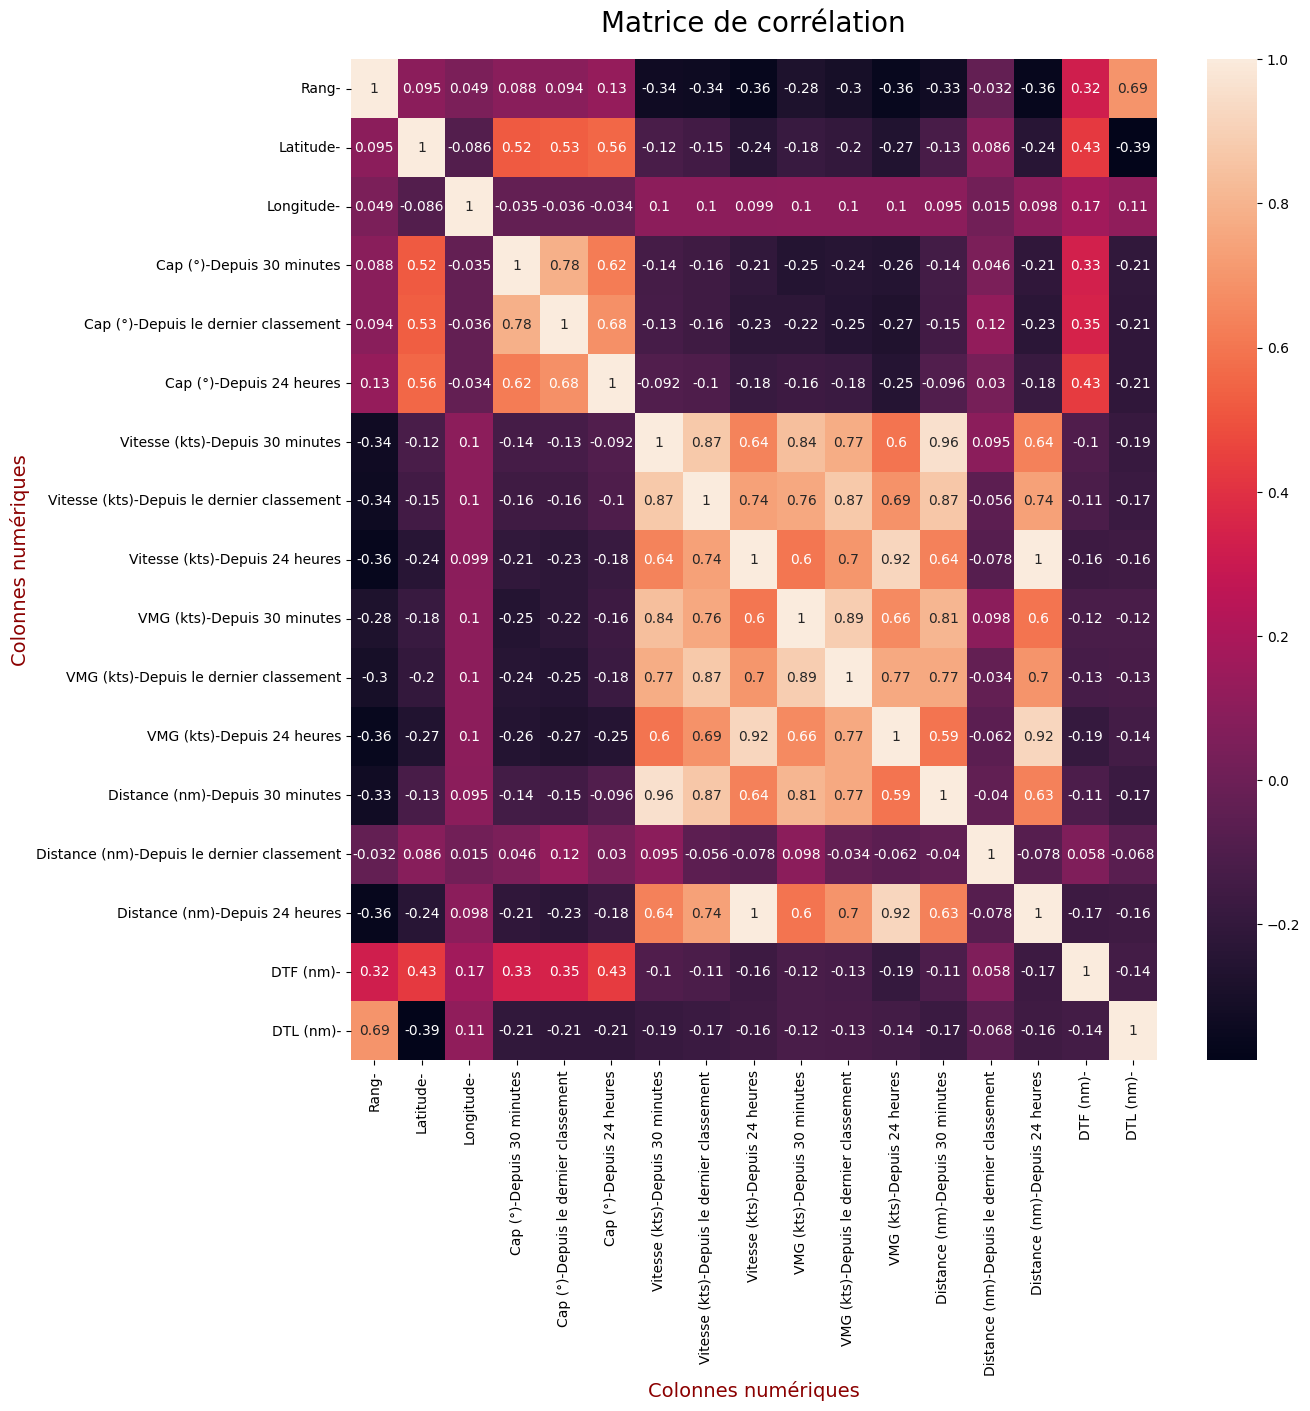

In [28]:
# Correlation matrix

plt.figure(figsize=(13,13))

plt.title('Matrice de corrélation', fontsize=20, pad=20)
sn.heatmap(df_classements.corr(numeric_only=True), annot = True)
plt.xlabel("Colonnes numériques", fontsize=14, color='darkred')
plt.ylabel("Colonnes numériques", fontsize=14, color='darkred')

plt.show()

### 3-2- Corrélation et régression linéaire entre le classement (rang) et la vitesse utile (VMG) des voiliers :

In [29]:
df1 = df_classements.groupby('Rang').agg({('VMG (kts)', 'Depuis le dernier classement'): 'mean'})
df1 = df1.droplevel(1, axis=1)
df1 = df1.reset_index()
df1 = df1.rename(columns={'VMG (kts)': 'VMG moyenne (kts)'})

df1

Rang  VMG moyenne (kts)
0      1          12.860825
1      2          12.815670
2      3          12.820206
3      4          12.709691
4      5          12.777320
5      6          12.697526
6      7          12.711546
7      8          12.563299
8      9          12.366804
9     10          12.321649
10    11          12.450928
11    12          11.920412
12    13          11.702062
13    14          11.999175
14    15          11.442680
15    16          11.398763
16    17          11.270309
17    18          11.513196
18    19          11.521031
19    20          11.249897
20    21          11.074021
21    22          11.006392
22    23          10.667423
23    24          10.290309
24    25           9.880619
25    26           8.798333
26    27           8.475989
27    28           9.142000
28    29           7.983436
29    30           7.796835
30    31           8.146795
31    32           8.251471
32    33           0.193617

In [30]:
print("Corrélation entre le rang et la vitesse utile moyenne : "+str(df1['Rang'].corr(df1['VMG moyenne (kts)'])))

Corrélation entre le rang et la vitesse utile moyenne : -0.8110886438639094


In [31]:
# Régression linéaire
X = np.asarray(df1['Rang'])
Y = np.asarray(df1['VMG moyenne (kts)'])

X = X.reshape(-1,1)

reg = lm.LinearRegression(fit_intercept=True)
reg.fit(X,Y)
Y_pred = reg.predict(X) # Valeurs prédites par le modèle

b0 = reg.intercept_
b1 = reg.coef_[0]
R2 = reg.score(X,Y)

SSE = np.sum((Y - Y_pred)**2) ### Error sum of squares
SSR = np.sum((Y_pred - Y.mean())**2) ### Regression sum of squares
SST = np.sum((Y - Y.mean())**2) ### Total sum of squares

print("intercept = " + str(round(b0,4)))
print("pente = " + str(round(b1,4)))
print("\nSSE = " + str(round(SSE,4)))
print("SSR = " + str(round(SSR,4)))
print("SST = " + str(round(SST,4)))
print("\nR2 = " + str(round(R2*100,2)) + "%")

intercept = 14.3156
pente = -0.2096

SSE = 68.3728
SSR = 131.4687
SST = 199.8415

R2 = 65.79%


In [32]:
# Analyse de la variance
pd.DataFrame(data = {'Source de variation': ['Expliquée', 'Résiduelle', 'Totale'],
                      'Somme des carrés': [SSR, SSE, SST], 
                      'ddl': [1, len(Y)-2, len(Y)-1],
                      'Carré moyen': [SSR, SSE/(len(Y)-2), SST/(len(Y)-1)]}).set_index('Source de variation')

Somme des carrés  ddl  Carré moyen
Source de variation                                    
Expliquée                  131.468713    1   131.468713
Résiduelle                  68.372828   31     2.205575
Totale                     199.841541   32     6.245048

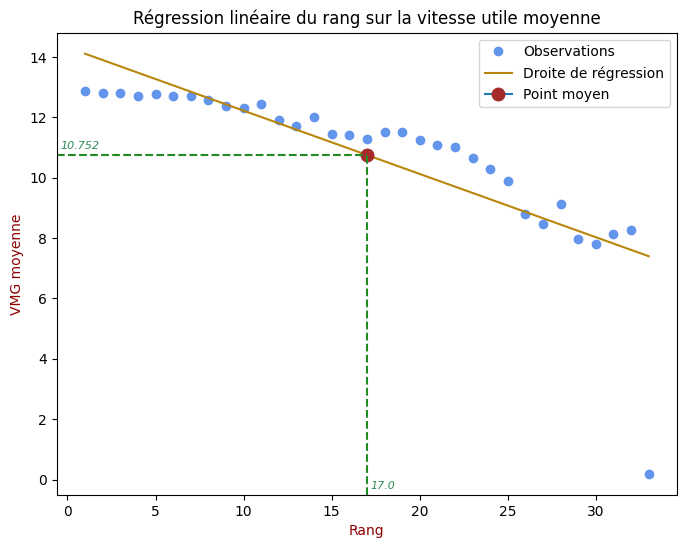

In [33]:
fig = plt.figure(figsize=(8,6))

plt.plot(X, Y, 'o', label="Observations", color="cornflowerblue")
plt.plot(X, Y_pred, label="Droite de régression", color="darkgoldenrod")

plt.plot(X.mean(), Y.mean(), marker='o', markersize=9, markeredgecolor='brown', markerfacecolor='brown', label="Point moyen")

axes = plt.gca()
x_min, x_max = axes.get_xlim()
y_min, y_max = axes.get_ylim()

xmax = (X.mean()-x_min)/(x_max-x_min)
ymax = (Y.mean()-y_min)/(y_max-y_min)

plt.axhline(y=Y.mean(), xmin=0, xmax=xmax, linestyle='--', color='forestgreen')
plt.axvline(x=X.mean(), ymin=0, ymax=ymax, linestyle='--', color='forestgreen')

plt.text(x_min+0.2, Y.mean()+0.2, str(round(Y.mean(),3)), fontstyle='italic', color='seagreen', fontsize=8)
plt.text(X.mean()+0.2, y_min+0.2, str(round(X.mean(),3)), fontstyle='italic', color='seagreen', fontsize=8)

plt.title("Régression linéaire du rang sur la vitesse utile moyenne")
plt.xlabel("Rang", color='darkred')
plt.ylabel("VMG moyenne", color='darkred')

plt.legend(loc='upper right')

plt.show()

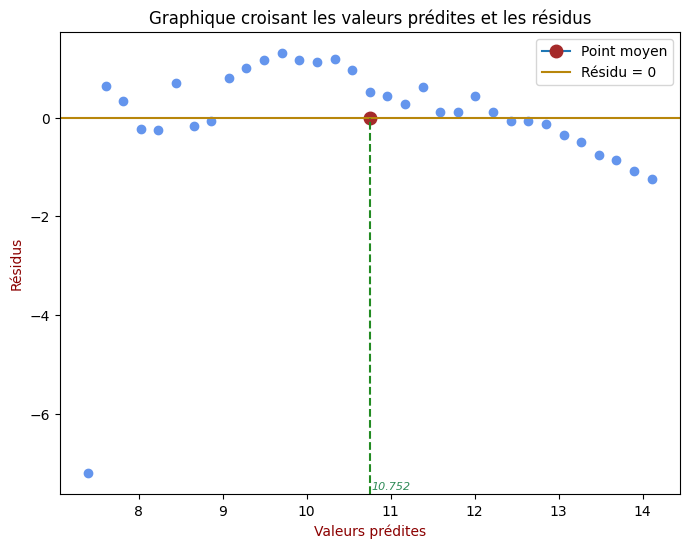

In [34]:
fig = plt.figure(figsize=(8,6))

plt.plot(Y_pred, Y-Y_pred, 'o', color="cornflowerblue")
plt.plot(Y.mean(), 0, marker='o', markersize=9, markeredgecolor='brown', markerfacecolor='brown', label="Point moyen")

plt.axhline(y=0, xmin=0, xmax=1, color='darkgoldenrod', label="Résidu = 0")

axes = plt.gca()
y_min, y_max = axes.get_ylim()

ymax = -y_min / (y_max-y_min)

plt.axvline(x=Y.mean(), ymin=0, ymax=ymax, linestyle='--', color='forestgreen')

plt.text(Y.mean()+0.02, y_min+0.1, str(round(Y.mean(),3)), fontstyle='italic', color='seagreen', fontsize=8)

plt.title("Graphique croisant les valeurs prédites et les résidus")
plt.xlabel("Valeurs prédites", color='darkred')
plt.ylabel("Résidus", color='darkred')

plt.legend(loc='upper right')

plt.show()

In [35]:
# Distance de Cook : Elle mesure l'impact de chaque observation sur l'équation de régression
model = sm.OLS(Y, sm.add_constant(X)).fit()
cooks = model.get_influence().cooks_distance

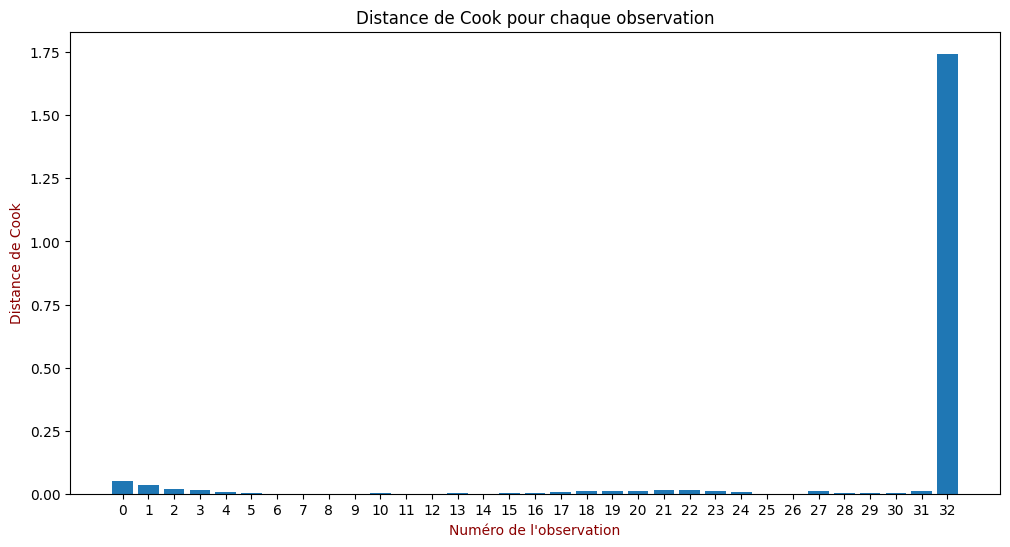

In [36]:
fig = plt.figure(figsize=(12,6))

plt.bar(list(range(len(df1))) , list(cooks[0]))

plt.xticks(list(range(len(df1))))

plt.title("Distance de Cook pour chaque observation")
plt.xlabel("Numéro de l'observation", color='darkred')
plt.ylabel("Distance de Cook", color='darkred')

plt.show()

La dernière observation (Rang = 33) est un point aberrant.

### 3-2- Distance parcourue par voilier (jusqu'au 27 Janvier 2021 à 14H) :

In [37]:
df2 = df_classements.groupby('Nom du skipper').agg({('Distance (nm)', 'Depuis le dernier classement'): 'sum'})
df2 = df2.droplevel(1, axis=1)
df2 = df2.reset_index()
df2 = df2.rename(columns={'Distance (nm)': 'Distance parcourue (nm)'})
df2['Distance parcourue (nm)'] = df2['Distance parcourue (nm)'].round(2)

df2

Nom du skipper  Distance parcourue (nm)
0             Alan ROURA                  26535.3
1           Alex THOMSON                  11119.0
2         Alexia BARRIER                  23137.2
3            Ari HUUSELA                  23749.3
4           Armel TRIPON                  29470.7
5      Arnaud BOISSIERES                  26505.9
6       Benjamin DUTREUX                  29647.9
7         Boris HERRMANN                  30508.0
8          Charlie DALIN                  31161.1
9        Clarisse CREMER                  28086.3
10        Clément GIRAUD                  25158.2
11         Damien SEGUIN                  29642.5
12           Didac COSTA                  26065.0
13        Fabrice AMEDEO                  11193.2
14      Giancarlo PEDOTE                  30173.9
15      Isabelle JOSCHKE                  23675.0
16           Jean LE CAM                  29483.6
17         Jérémie BEYOU                  28831.4
18       Kevin ESCOFFIER                  10450.0
19      Kojiro SHIRAISHI                  26848.9
20          Louis BURTON                  30753.0
21         Manuel COUSIN                  25740.1
22          Maxime SOREL                  28927.4
23        Miranda MERRON                  24852.2
24      Nicolas TROUSSEL                   5274.3
25              Pip HARE                  25805.4
26      Romain ATTANASIO                  27160.6
27       Samantha DAVIES                  11444.8
28  Stéphane LE DIRAISON                  26646.3
29   Sébastien DESTREMAU                  18715.3
30       Sébastien SIMON                  11478.6
31         Thomas RUYANT                  30991.2
32      Yannick BESTAVEN                  30507.5

In [38]:
fig = make_subplots(
    rows=2, cols=1,
    shared_xaxes=False,
    shared_yaxes=False,
    vertical_spacing=0.02,
    specs=[[{"type": "table"}],
           [{"type": "bar"}]],
    row_heights=[1,1.2]
)

fig.add_trace(go.Bar(x=df2['Nom du skipper'],
                     y=df2['Distance parcourue (nm)'],
                     marker=dict(color=df2['Distance parcourue (nm)'], 
                                 colorscale='earth', 
                                 showscale=True,
                                 colorbar=dict(len=0.55, x=1.02 ,y=0.27)),
                     hoverlabel=dict(namelength=0)),
              row=2, col=1)

fig.update_xaxes(title="Nom du skipper", title_font=dict(size=20, family='Open Sans', color='#AD2C30'), row=2, col=1)
fig.update_yaxes(title="Distance parcourue (nm)", title_font=dict(size=20, family='Open Sans', color='#AD2C30'), row=2, col=1)

fig.update_layout(height=1200,
                  title="Distance parcourue par voilier (jusqu'au 27 Janvier 2021 à 14H)",
                  title_x=0.5,
                  title_font_family="Times New Roman",
                  title_font_size=22,
                  title_font_color="darkred",
                  font=dict(size=12, color="#150E68")
                 )

fig.add_trace(go.Table(header=dict(values=["Nom du skipper", "Distance parcourue (nm)"], 
                                   font=dict(size=16, color='black'), 
                                   align="center",
                                   fill_color='#FBF8E4',
                                   line_color='lightgrey'),
                       cells=dict(values=[df2[k].tolist() for k in df2.columns], 
                                  align = "center",
                                  fill_color='#FFFEF8',
                                  line_color='lightgrey',
                                  height=22)),
              row=1, col=1
             )

fig.show()

### 3-3- Distance parcourue par voilier en fonction de la date du classement :

In [39]:
df3 = df_classements[['Nom du skipper', 'Distance (nm)']]
df3 = df3.droplevel(1, axis=0)
df3 = df3.reset_index()
df3 = df3.set_index(['Nom du skipper', 'Date du classement']).sort_values(['Nom du skipper', 'Date du classement'])
df3 = df3.droplevel(0, axis=1)
df3 = df3.drop(['Depuis 30 minutes', 'Depuis 24 heures'], axis=1)
df3 = df3.rename(columns={'Depuis le dernier classement': 'Distance parcourue (nm)'})
df3 = df3.groupby('Nom du skipper').cumsum()

df3

Distance parcourue (nm)
Nom du skipper   Date du classement                          
Alan ROURA       2020-11-08 14:00:00                   2789.2
                 2020-11-08 15:00:00                   2812.2
                 2020-11-08 17:00:00                   2841.1
                 2020-11-08 21:00:00                   2897.4
                 2020-11-09 04:00:00                   2971.8
...                                                       ...
Yannick BESTAVEN 2021-01-26 21:00:00                  30189.3
                 2021-01-27 04:00:00                  30326.2
                 2021-01-27 08:00:00                  30403.3
                 2021-01-27 11:00:00                  30453.1
                 2021-01-27 14:00:00                  30507.5

[13784 rows x 1 columns]

In [40]:
fig = make_subplots(rows=1, cols=1)


for i in df3.index.levels[0]:
    df_dist = df3.loc[i,:].reset_index()
    fig.add_trace(go.Scatter(x=df_dist['Date du classement'], 
                             y=df_dist['Distance parcourue (nm)'], 
                             mode='lines',
                             name=i))    

fig.update_xaxes(title="Date du classement", 
                 title_font=dict(size=20, family='Open Sans', color='#546E09'), 
                 row=1, col=1,
                 rangeslider_visible=True,
                 nticks=20)

fig.update_yaxes(title="Distance parcourue (nm)", 
                 title_font=dict(size=20, family='Open Sans', color='#546E09'), 
                 row=1, col=1)

fig.update_layout(height=900,
                  title="Distance parcourue par voilier en fonction de la date du classement",
                  title_x=0.5,
                  title_font_family="Times New Roman",
                  title_font_size=22,
                  title_font_color="darkred",
                  font=dict(size=14, color="RebeccaPurple"))


fig.show()

### 3-4- Distance restante par voilier en fonction de la date du classement :

In [41]:
df4 = df_classements[['Nom du skipper', 'DTF (nm)']]
df4 = df4.droplevel(1, axis=0)
df4 = df4.reset_index()
df4 = df4.set_index(['Nom du skipper', 'Date du classement']).sort_values(['Nom du skipper', 'Date du classement'])
df4 = df4.rename(columns={'DTF (nm)': 'Distance restante (nm)'})

df4

Distance restante (nm)
                                                           
Nom du skipper   Date du classement                        
Alan ROURA       2020-11-08 14:00:00                24295.3
                 2020-11-08 15:00:00                24273.5
                 2020-11-08 17:00:00                24250.0
                 2020-11-08 21:00:00                24208.9
                 2020-11-09 04:00:00                24154.1
...                                                     ...
Yannick BESTAVEN 2021-01-26 21:00:00                  578.2
                 2021-01-27 04:00:00                  443.9
                 2021-01-27 08:00:00                  367.8
                 2021-01-27 11:00:00                  318.4
                 2021-01-27 14:00:00                  264.3

[13784 rows x 1 columns]

In [42]:
fig = make_subplots(rows=1, cols=1)


for i in df4.index.levels[0]:
    df_dist = df4.loc[i,:].reset_index()
    fig.add_trace(go.Scatter(x=df_dist['Date du classement'], 
                             y=df_dist['Distance restante (nm)'], 
                             mode='lines',
                             name=i))    

fig.update_xaxes(title="Date du classement", 
                 title_font=dict(size=20, family='Open Sans', color='#546E09'), 
                 row=1, col=1,
                 rangeslider_visible=True,
                 nticks=20)

fig.update_yaxes(title="Distance restante (nm)", 
                 title_font=dict(size=20, family='Open Sans', color='#546E09'), 
                 row=1, col=1)

fig.update_layout(height=900,
                  title="Distance restante par voilier en fonction de la date du classement",
                  title_x=0.5,
                  title_font_family="Times New Roman",
                  title_font_size=22,
                  title_font_color="darkred",
                  font=dict(size=14, color="RebeccaPurple"))


fig.show()

### 3-5- Impact de la présence d'un foil sur le classement et la vitesse des voiliers :

In [43]:
df5 = df_classements.groupby('Nom du skipper').agg({('VMG (kts)', 'Depuis le dernier classement'): 'mean'})
df5 = df5.droplevel(1, axis=1)
df5 = df5.reset_index()
df5 = df5.rename(columns={'VMG (kts)': 'VMG moyenne (kts)'})

df5 = pd.merge(df5,
               df_classements.loc[datetime.datetime(2021,1,27,14,0,0),['Nom du skipper', 'Rang']].droplevel(1, axis=1),
               left_on='Nom du skipper',
               right_on='Nom du skipper',
               how='inner')

df5 = df5.rename(columns={'Rang': 'Rang au classement du 27 janvier 2021 à 14h'})

df5 = pd.merge(df5,
               df_boats_infos.reset_index()[['Nom du skipper', 'Nombre de dérives', 'Voile quille',
                                             'Largeur', 'Déplacement (poids)', 'Hauteur mât',
                                             'Surface de voiles au près', 'Surface de voiles au portant']],
               left_on='Nom du skipper',
               right_on='Nom du skipper',
               how='inner')

df5.sort_values('Rang au classement du 27 janvier 2021 à 14h').set_index('Nom du skipper')

VMG moyenne (kts)  \
Nom du skipper                            
Charlie DALIN                 12.805165   
Louis BURTON                  12.836701   
Boris HERRMANN                12.774433   
Thomas RUYANT                 12.685773   
Yannick BESTAVEN              12.713814   
Damien SEGUIN                 12.646392   
Giancarlo PEDOTE              12.632371   
Jean LE CAM                   12.491340   
Benjamin DUTREUX              12.451546   
Maxime SOREL                  12.287423   
Armel TRIPON                  12.247010   
Clarisse CREMER               11.941237   
Romain ATTANASIO              11.424330   
Jérémie BEYOU                 11.335464   
Kojiro SHIRAISHI              10.968866   
Stéphane LE DIRAISON          10.988247   
Pip HARE                      10.887835   
Didac COSTA                   10.798969   
Manuel COUSIN                 10.294021   
Miranda MERRON                10.223505   
Clément GIRAUD                10.278144   
Alexia BARRIER                 9.504124   
Ari HUUSELA                    9.370722   

                      Rang au classement du 27 janvier 2021 à 14h  \
Nom du skipper                                                      
Charlie DALIN                                                   1   
Louis BURTON                                                    2   
Boris HERRMANN                                                  3   
Thomas RUYANT                                                   4   
Yannick BESTAVEN                                                5   
Damien SEGUIN                                                   6   
Giancarlo PEDOTE                                                7   
Jean LE CAM                                                     8   
Benjamin DUTREUX                                                9   
Maxime SOREL                                                   10   
Armel TRIPON                                                   11   
Clarisse CREMER                                                12   
Romain ATTANASIO                                               13   
Jérémie BEYOU                                                  14   
Kojiro SHIRAISHI                                               17   
Stéphane LE DIRAISON                                           18   
Pip HARE                                                       19   
Didac COSTA                                                    20   
Manuel COUSIN                                                  21   
Miranda MERRON                                                 22   
Clément GIRAUD                                                 23   
Alexia BARRIER                                                 24   
Ari HUUSELA                                                    25   

                     Nombre de dérives                      Voile quille  \
Nom du skipper                                                             
Charlie DALIN                    foils                             acier   
Louis BURTON                     foils                             acier   
Boris HERRMANN                   foils                             acier   
Thomas RUYANT                    foils                       acier forgé   
Yannick BESTAVEN                 foils                acier mécano soudé   
Damien SEGUIN                        2                       acier forgé   
Giancarlo PEDOTE                 foils                       acier forgé   
Jean LE CAM                          2                       acier forgé   
Benjamin DUTREUX                     2                       acier forgé   
Maxime SOREL                         2                             acier   
Armel TRIPON                     foils                       acier forgé   
Clarisse CREMER                      2                       acier forgé   
Romain ATTANASIO                     2                       acier forgé   
Jérémie BEYOU                    foils                             acier   
Koji

On remarque que les foils sont présents au niveau des 5 premiers rang.

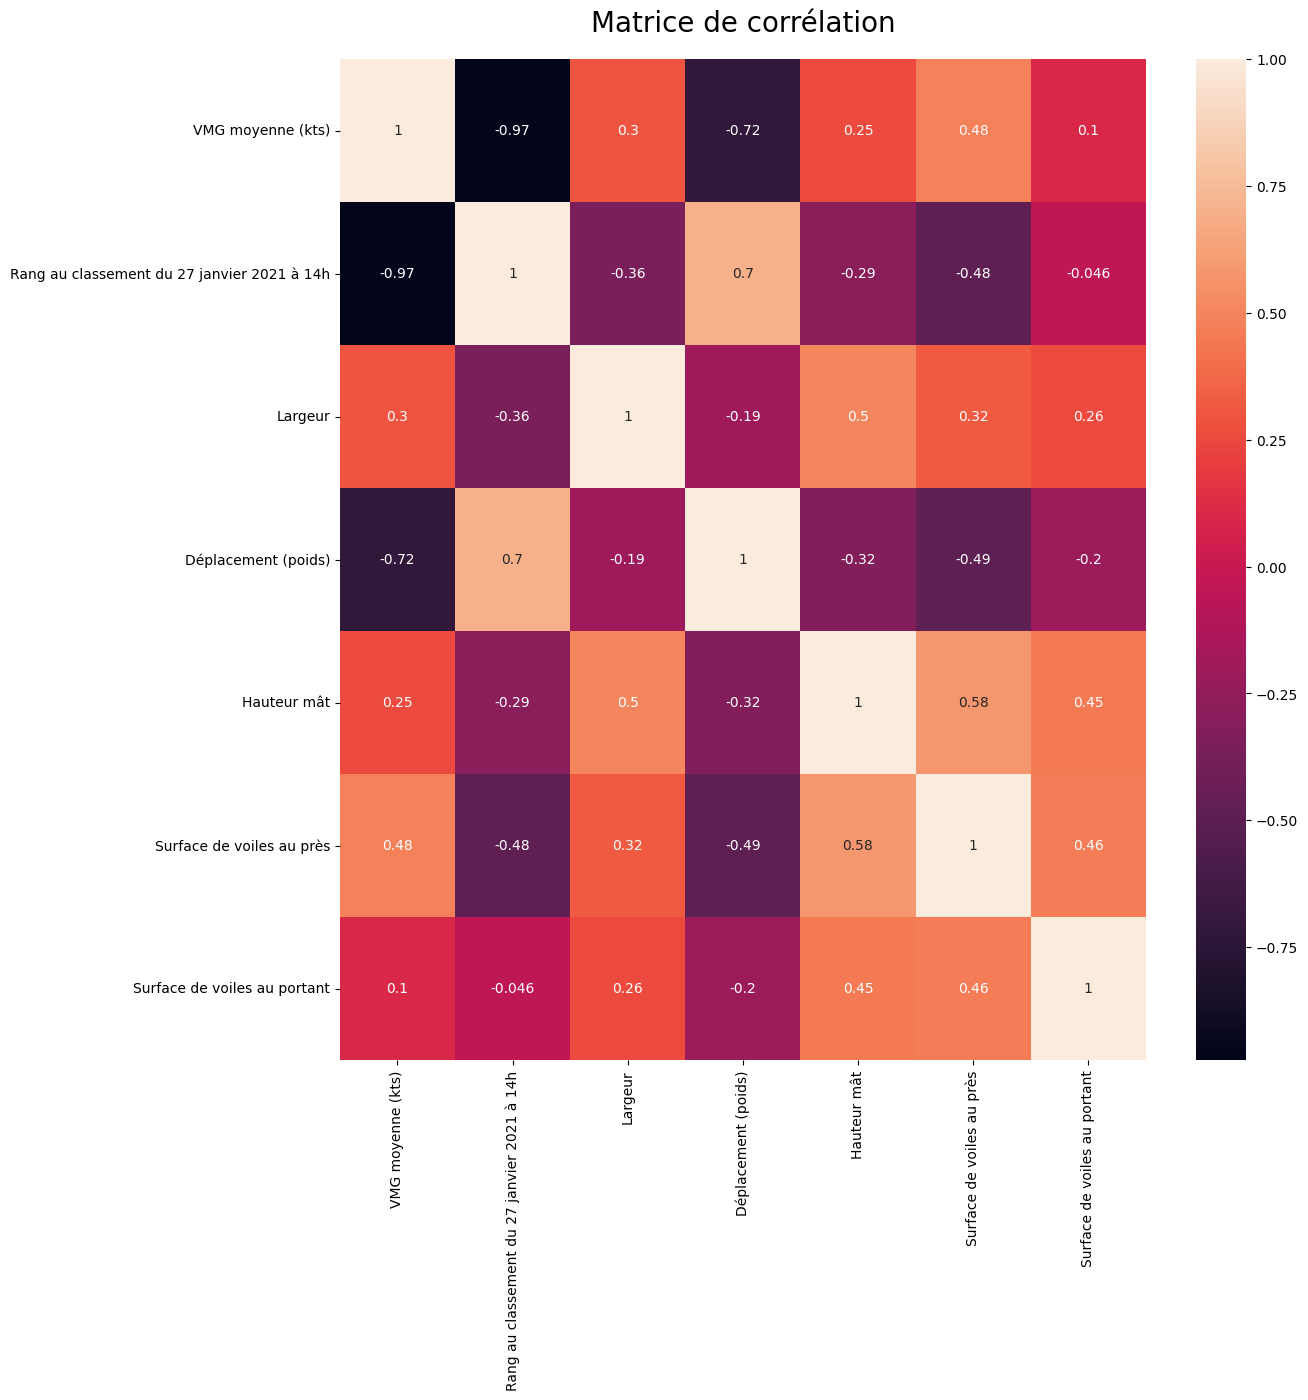

In [44]:
# Correlation matrix

plt.figure(figsize=(13,13))

plt.title('Matrice de corrélation', fontsize=20, pad=20)
sn.heatmap(df5.corr(numeric_only=True), annot = True)

plt.show()

On remarque aussi que le déplacement impacte considérablement le classement (corrélation = 0.7).

### 3-6- Cartes avec les routes d'un ou plusieurs voiliers :

On utilisera pour cette partie les coordonnées géorgraphiques (Latitude, Longitude) ainsi que la date du classement, et ceci pour chaque voilier.

In [45]:
df6 = df_classements[['Nom du skipper', 'Latitude', 'Longitude']]
df6 = df6.droplevel(1, axis=0)
df6 = df6.reset_index()
df6 = df6.set_index(['Nom du skipper','Date du classement']).sort_values(['Nom du skipper','Date du classement'])

df6

Latitude  Longitude
                                                          
Nom du skipper   Date du classement                       
Alan ROURA       2020-11-08 14:00:00  46.436667  -1.826667
                 2020-11-08 15:00:00  46.358889  -2.370278
                 2020-11-08 17:00:00  46.391111  -3.066111
                 2020-11-08 21:00:00  46.470000  -4.426389
                 2020-11-09 04:00:00  46.339444  -6.205833
...                                         ...        ...
Yannick BESTAVEN 2021-01-26 21:00:00  47.595833 -15.841667
                 2021-01-27 04:00:00  47.878889 -12.467222
                 2021-01-27 08:00:00  47.893611 -10.553056
                 2021-01-27 11:00:00  47.850278  -9.317500
                 2021-01-27 14:00:00  47.727222  -7.989167

[13784 rows x 2 columns]

In [46]:
fig = make_subplots(rows=1, cols=1)

for i in df6.index.levels[0]:
    df_dist = df6.loc[i,:].reset_index()
    fig.add_trace(go.Scattergeo(lat=df_dist['Latitude'], 
                                lon=df_dist['Longitude'], 
                                mode='markers+lines',
                                marker_size=2,
                                line_width=1,
                                name=i,
                                hovertext=df_dist['Date du classement']))    

fig.update_geos(visible=False,
                resolution=110,
                showcountries=True,
                countrycolor="slategrey",
                lataxis_showgrid=True,
                lataxis_gridcolor="lightgrey",
                lonaxis_showgrid=True,
                lonaxis_gridcolor="lightgrey",
                showocean=True,
                oceancolor="lightcyan",
                showland=True,
                landcolor="moccasin")

fig.update_layout(margin={"t": 0, "b": 0, "l": 0, "r": 0}, width=985, height=660, legend=dict(orientation="h"))

fig.show()